In [779]:
#I is the Nx1 vector containing the status of each farm
#I=0 Susceptible
#I=1 Exposed
#I=2 Infectious
#I=3 Reported
#I=4 Culled

#s = Nx1 vector containing latent period of each farm 

#r = Nx1 vector containing infectious period of each farm

#A is the Nx6 matrix containing
#column1: Index of the farm
#column2: Day number at which the farm became exposed
#column3: Latent period of the farm
#column4: Infectious period of the farm

#toBeCulled is an Nx2 matrix containing information about farms that need to be Culled
#column1: Index of the farm
#column2: Time that has passed since its infectious period finished
#N.B. By infectious period, this means the time after which it can be culled.
#The farm is still infectious once the infectious period has passed.

#toBeCulledOrdered is the same matrix as above, except the farms have been ordered
#by the length of time they have been waiting to be culled

In [780]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
from matplotlib import animation
import time
import pandas as pd
import multiprocessing
import itertools
from scipy.spatial import distance
import networkx as nx
np.set_printoptions(threshold=np.nan)
import os

#os.chdir('/Users/apple/Desktop/group/data');
np.random.seed(5761)
countyNumber = 8

In [781]:
#Import 2010 Farm Data
farmData=pd.read_csv("Farms_2010_RSG",names=["County Number", "Parish Number", "Holding Number", 
                                               "X Coordinate", "Y Coordinate", "Number of Cattle", 
                                               "Number of Sheep"],delim_whitespace=True)
cumbData = farmData[farmData['County Number'] == countyNumber]
print(len(cumbData))
#cumbData = farmData
#cumbData = cumbData.reset_index(drop=True) # to be consistent with movement data

#Import 2010 batch size movement data
movBatchSize=pd.read_csv("aggmovementdata_2010_2.txt",names=["CTS Off Farm", "CTS On Farm", "CTS Market", 
                                               "Day Number", "Number of Animals Moved"])
movBatchSize = movBatchSize[movBatchSize['CTS On Farm'] != -1]
movBatchSize = movBatchSize[movBatchSize['CTS Off Farm'] != -1]
movBatchSize = movBatchSize[movBatchSize['CTS Market'] == -1]

#Import CTS data file and restrict to countyNumber
ctsKeys=pd.read_csv("cts_keys.csv",names=["Off CTS Number", "On CTS Number", "County", "Parish", "Holding"])
cumbCtsKeys = ctsKeys[ctsKeys['County'] == countyNumber]
print(len(cumbCtsKeys))

#Merge CTS dataframe with cumbData according to parish and holding number
pd.options.display.max_rows = 5000
mergeCumbData = cumbData.merge(cumbCtsKeys, left_on=["Parish Number", "Holding Number"], right_on=["Parish", "Holding"], how='left')
mergeCumbData = mergeCumbData.drop(["County", "Parish", "Holding"], axis=1)
print(len(mergeCumbData))

xCumb = 1.0*cumbData['X Coordinate']/100000
yCumb = 1.0*cumbData['Y Coordinate']/100000
xmax = np.max(xCumb)
xmin = np.min(xCumb)
ymax = np.max(yCumb)
ymin = np.min(yCumb)
sizex = xmax-xmin
sizey = ymax-ymin
xcoord = xCumb - xmin #Shift to start from (0, 0)
ycoord = yCumb - ymin #Shift to start from (0, 0)
N=np.size(xcoord)

cattleFrame = cumbData['Number of Cattle']
sheepFrame = cumbData['Number of Sheep']

offCTS = mergeCumbData['Off CTS Number']
onCTS = mergeCumbData['On CTS Number']

numAnimalsMoved = movBatchSize['Number of Animals Moved'].values
lenMovement = len(numAnimalsMoved)

print(len(offCTS))
print(len(onCTS))

4340
10139
4371
4371
4371


In [782]:
CumbNum=cumbData.index.values+1 # farm number is from 1 to coincide with movement data

In [783]:
# movement data
Movement=pd.read_csv('movements_unique', 
                       names = ["From", "To", "Weight"], delim_whitespace=True)
Movement=np.absolute(Movement);

# take movement from CumbNum to CumbNum
CumbMoveInt=Movement[Movement['From'].isin(CumbNum)]
CumbMove=CumbMoveInt[CumbMoveInt['To'].isin(CumbNum)]
print(len(CumbMove))

CumbMoveFrom=CumbMove['From'].values.astype(int)
print(len(CumbMoveFrom))
CumbMoveTo=CumbMove['To'].values.astype(int)
CumbMoveW=CumbMove['Weight'].values

35281
35281


In [784]:
#Import movement data, and get movements to and from county countyNumber only.
# movementData = pd.read_csv("movements_unique",header=None, delim_whitespace=True)

# farmNumFrom=movementData.values[:,0]
# farmNumTo=movementData.values[:,1]
# weightLink=movementData.values[:,2]

# county2010=farmData.values[:,0]
# countyTo=np.zeros(len(farmNumTo))
# for i in range(len(farmNumTo)):
#     countyTo[i]=county2010[int(farmNumTo[i])-1]
    
# countyFrom=np.zeros(len(farmNumFrom))
# for i in range(len(farmNumFrom)):
#     countyFrom[i]=county2010[int(farmNumFrom[i])-1]
# movementData[3]=countyFrom
# movementData[4]=countyTo

# cumbMovement = []
# for i in range(len(countyTo)):
#     if ((countyTo[i]==countyNumber) and (countyFrom[i]==8)):
#         cumbMovement.append(i)
        
# cumbMovNet = movementData[(movementData[3]==8) & (movementData[4] == 8)]
# cumbMovNet2 = pd.DataFrame()
# cumbMovNet2['Farm From'] = cumbMovNet[0].astype(int)
# cumbMovNet2['Farm To'] = cumbMovNet[1].astype(int)
# cumbMovNet2['Weight'] = cumbMovNet[2]

# cumbMovNet2.to_csv('cumbMovNet2.csv', index=False, header=False)
# G=nx.read_edgelist('cumbMovNet2.csv', delimiter=',', nodetype=int, data=[('weight',float)], create_using=nx.DiGraph())
# G.get_edge_data(7298, 9324)['weight']

In [785]:
#Calculate Euclidean distances
xinput = xcoord.values
yinput = ycoord.values
joinedinput = np.column_stack((xinput, yinput))
dist = distance.cdist(joinedinput, joinedinput, 'euclidean')

In [786]:
#Parameter values     
# psi = 0.00657
# nu = 1.99*(10**(-7))
# xi = 2.65
# zeta = 1.80
# chi = 0.403
nu=5.1e-7
xi=7.7e-7
zeta=10.5
chi=1
s = np.random.negative_binomial(50, 1.0*50/55, N) #Draw latent periods
r = np.random.negative_binomial(30, 1.0*30/39, N) #Draw infectious periods

t = 1
A = np.zeros(shape=(N,4), dtype=np.int64)

a1=0.1 #CumbMoveFrom movement rate reduction when reported
a2=0.1 #CumbMoveTo movement rate reduction when reported
#output = np.zeros(shape=(N,6))

#resourceNum=10 #Number of farms that can be culled each day

numCattleBanned = 0
numSheepBanned = 0

numMovementsBanned = 0

move=0
move2=0

cattle = abs(cattleFrame.values)
sheep = abs(sheepFrame.values)

In [726]:
#Calculate distance kernel
# K = psi**2/(psi**4 + dist**4)

# K[np.where(dist > 0.5)] = 0

kernelData=pd.read_csv('Kernel',header=None,delim_whitespace=True)
kernelDist = kernelData.values[:,0]
kernelValue = kernelData.values[:,1]
zeroDistKernel = 1
roundDist = np.rint(dist*1000)

K = np.zeros(shape=(N,N))
for i in range(len(roundDist)):
    for j in range(len(roundDist)):
        if (roundDist[i,j] != 0) & (roundDist[i,j] <= 200):
            K[i,j] = kernelValue[int(roundDist[i,j])-1]
        elif roundDist[i,j] > 200:
            K[i,j] = 0
        elif roundDist[i,j] == 0:
            K[i,j] = kernelValue[0]

In [787]:
#Choose initial case

initial1 = random.randint(0,N)
initial2=initial1+1
initial3=initial2+1
initial4=initial3+1

I = np.zeros(N, dtype=np.int64)

I[initial1] = 1
I[initial2] = 1
I[initial3] = 1
I[initial4] = 1

A[initial1, ] = [initial1, 0, s[initial1], r[initial1]]
A[initial2, ] = [initial2, 0, s[initial2], r[initial2]]
A[initial3, ] = [initial3, 0, s[initial3], r[initial3]]
A[initial4, ] = [initial4, 0, s[initial4], r[initial4]]

In [788]:
# quantities which are useful for limited resource ring cull
culledind=[] 
IP=[]
RC=[]
Capacity=50 # capacity for culling

# quantities which are useful for movement count
count_move=0 #Number of movements that lead to infection

# quantities which are useful for local movement constrain
MoveRange=1.0*5000/100000 
MoveCons=[]

#quantities which are useful for farm-specific local movement constrain
k=(10000-0)/(2*(max(cattle+sheep)-min(cattle+sheep)))
FarmMoveRange=k*(cattle+sheep)/100000
#FarmMoveRange=1.0*100*np.ones(len(cattle))/100000

# quantities which are useful for ring cull
RingCull=1.0*3000/100000 
#RingCull=0

count_move2=0 #Number of movements

In [789]:
# for plot purpose
reportind = [i for i in range(np.size(I)) if I[i]==3]
infectind = [i for i in range(np.size(I)) if I[i]==2]
exposedind = [i for i in range(np.size(I)) if I[i]==1]

Exp=[len(exposedind)]
Inf=[len(infectind)]
Rep=[len(reportind)]

CullSheep=[0]
CullCattle=[0]
time_plot=[0]

<IPython.core.display.Javascript object>


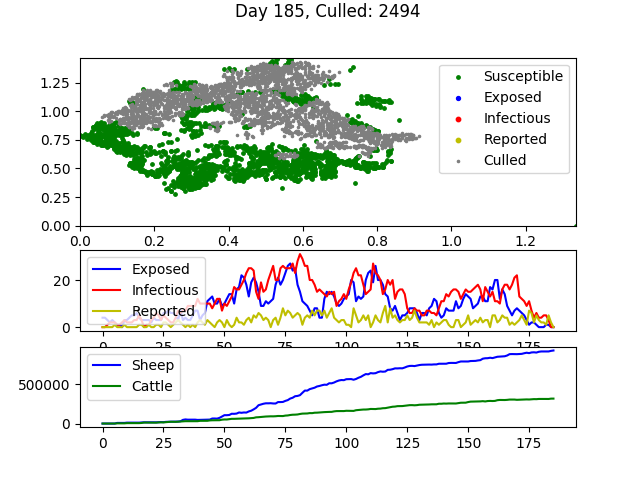

MoveCons []
repCattle []
repSheep []
MoveCons []
repCattle []
repSheep []
IP []
RC []
MoveCons []
repCattle []
repSheep []
IP []
RC []
MoveCons []
repCattle []
repSheep []
IP []
RC []
MoveCons []
repCattle []
repSheep []
IP []
RC []
MoveCons [7607, 7608, 7626, 7675, 7881, 7882, 7883, 7884, 7885, 7887, 7888, 7890, 7891, 7892, 7895, 7896, 7897, 7900, 7901, 7902, 7903, 7904, 7906, 7907, 7908, 7909, 7910, 7913, 7914, 7921, 7949, 7982, 7986, 7994, 8475, 8476, 8477, 8478, 8479, 8480, 8481, 8482, 8483, 8484, 8485, 8486, 8487, 8488, 8489, 8490, 8500, 8525, 8597, 8598, 8599, 8600, 8602, 8603, 8615, 8616, 8617, 8618, 8620, 8621, 8623, 8626, 8628, 8629, 8633, 8634, 8635, 8636, 8663, 8664, 8665, 8667, 8668, 8669, 8670, 8671, 9791, 9792, 9906]
repCattle [90.67]
repSheep [471.]
IP []
RC []
MoveCons []
repCattle []
repSheep []
IP []
RC []
MoveCons []
repCattle []
repSheep []
IP []
RC []
MoveCons []
repCattle []
repSheep []
IP []
RC []
MoveCons [7608, 7661, 7675, 7677, 7874, 7878, 7881, 7882, 7883, 78

IP []
RC []
MoveCons [7606, 7610, 7611, 7612, 7614, 7615, 7616, 7617, 7619, 7620, 7621, 7622, 7623, 7625, 7627, 7637, 7638, 7642, 7643, 7645, 7646, 7647, 7648, 7649, 7650, 7651, 7653, 7654, 7655, 7656, 7657, 7658, 7659, 7660, 7668, 7670, 7671, 7672, 7673, 7674, 7676, 7801, 7802, 7814, 7816, 7817, 7818, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7853, 7856, 7860, 7862, 7864, 7866, 7870, 7871, 7873, 7898, 7899, 7950, 9878, 9879, 9880, 9881, 9882, 9884, 9885, 9886, 9887, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9900, 9901, 9902, 9903, 9904, 9905, 9911, 9913, 9916, 7646, 7647, 7648, 7650, 7651, 7652, 7653, 7657, 7658, 7668, 7672, 7673, 7674, 7676, 7679, 7681, 7683, 7684, 7686, 7687, 7689, 7690, 7692, 7695, 7696, 7698, 7701, 7702, 7703, 7704, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7729, 7739, 7744, 7745, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7842, 7843, 7844, 7847, 7848, 7849, 7852, 7853, 7857, 7870, 7950, 9878, 9879, 

IP []
RC []
MoveCons [7606, 7610, 7611, 7612, 7619, 7620, 7621, 7622, 7645, 7646, 7647, 7648, 7649, 7650, 7651, 7652, 7653, 7654, 7655, 7656, 7657, 7658, 7659, 7660, 7663, 7665, 7666, 7668, 7670, 7671, 7672, 7673, 7674, 7676, 7679, 7684, 7692, 7695, 7696, 7704, 7708, 7710, 7711, 7712, 7744, 7801, 7802, 7818, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7848, 7853, 7856, 7857, 7860, 7864, 7866, 7870, 7871, 7873, 7898, 7899, 7950, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9892, 9894, 9895, 9896, 9897, 9898, 9900, 9902, 9903, 9905, 9911, 9916, 7646, 7647, 7648, 7650, 7651, 7652, 7653, 7657, 7658, 7660, 7668, 7672, 7673, 7674, 7676, 7679, 7681, 7683, 7684, 7686, 7687, 7689, 7690, 7692, 7695, 7696, 7698, 7701, 7702, 7703, 7704, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7729, 7739, 7744, 7745, 7830, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7842, 7843, 7844, 7847, 7848, 7849, 7852, 7853, 7857, 7860, 7870, 7873, 

IP []
RC []
MoveCons [7613, 7614, 7615, 7616, 7617, 7618, 7619, 7620, 7621, 7622, 7623, 7627, 7628, 7629, 7630, 7631, 7632, 7633, 7634, 7635, 7636, 7637, 7639, 7640, 7641, 7642, 7643, 7644, 7788, 7789, 7790, 7796, 7797, 7798, 7799, 7800, 7801, 7802, 7803, 7804, 7805, 7806, 7807, 7808, 7813, 7814, 7816, 7817, 7818, 7820, 7821, 7822, 7823, 7824, 7827, 7829, 7830, 7831, 7840, 7841, 7846, 7856, 7858, 7862, 7864, 7866, 7912, 7956, 7966, 7968, 7977, 8020, 8022, 9893, 9897, 9899, 9900, 9901, 9904, 9909, 9911, 9914]
repCattle [126.33]
repSheep [31.]
IP []
RC []
MoveCons []
repCattle []
repSheep []
IP []
RC []
MoveCons [9968, 9974, 9977, 9978, 9979, 9981, 9982, 9984, 9985, 9986, 9987, 9993, 9994, 9995, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10038, 10039, 10041, 10042, 10043, 10047, 10048, 10050, 10051, 10053, 10054, 10056, 10057, 10058, 10059, 10060, 10191, 10192, 10193, 10194, 10195, 10196, 10197, 10198, 10199, 10200, 10271, 10276, 10833, 10837, 10838, 10840, 10841, 10843, 108

IP []
RC []
MoveCons [7609, 7610, 7611, 7612, 7613, 7614, 7615, 7616, 7617, 7618, 7619, 7620, 7621, 7622, 7623, 7624, 7625, 7627, 7628, 7629, 7630, 7631, 7632, 7635, 7636, 7637, 7638, 7639, 7640, 7641, 7642, 7643, 7644, 7645, 7649, 7651, 7653, 7654, 7660, 7670, 7671, 7796, 7799, 7800, 7801, 7802, 7805, 7807, 7813, 7814, 7816, 7817, 7818, 7821, 7822, 7827, 7829, 7830, 7831, 7832, 7834, 7835, 7836, 7840, 7841, 7842, 7844, 7845, 7846, 7847, 7856, 7862, 7864, 7866, 7870, 7873, 7898, 7905, 7912, 7954, 7956, 7968, 7977, 9892, 9893, 9894, 9895, 9896, 9897, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9911, 9916, 9117, 9119, 9122, 9123, 9129, 9131, 9132, 9352, 9432, 10766, 10767, 10768, 10769, 10770, 10771, 10772, 10774, 10775, 10776, 10777, 10778, 10800, 10801, 10802, 10803, 10804, 10805, 10806, 10807, 10808, 10809, 10867, 10869, 10871, 10896, 10897, 10999, 11000, 11001, 11025, 11026, 11027, 9330, 10766, 10767, 10768, 10769, 10770, 10771, 10772, 10777, 10820, 10823, 10824, 10826, 10828, 10830, 1

IP []
RC [3730, 3731]
MoveCons [9116, 9117, 9118, 9119, 9121, 9123, 9126, 9247, 9248, 9250, 9251, 9252, 9255, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9332, 9334, 9336, 9339, 9340, 9341, 9342, 9344, 9345, 9347, 9348, 9349, 9351, 9353, 9354, 9418, 9419, 10800, 10801, 10802, 10803, 10804, 10805, 10806, 10807, 10808, 10809, 10901, 10904, 9968, 9969, 9971, 9973, 9974, 9976, 9977, 9978, 9979, 9981, 9982, 9983, 9984, 9985, 9986, 9987, 9988, 9991, 9993, 9994, 9995, 10029, 10032, 10033, 10034, 10035, 10050, 10051, 10053, 10054, 10056, 10057, 10058, 10059, 10129, 10130, 10132, 10133, 10134, 10191, 10192, 10193, 10194, 10195, 10196, 10197, 10198, 10199, 10200, 10271, 10273, 10276, 10279, 10282, 10283, 10290, 10833, 10841, 10845, 10850, 10860, 10882, 10885, 11030, 11031, 11032, 11033, 11034, 11036, 11038, 11039, 11040, 11041, 11042, 11043, 11044, 11049, 11050, 11051, 11055, 10766, 10767, 10768, 10769, 10770, 10771, 10772, 10773, 10774, 10775, 10776, 10777, 10778, 10781, 10782, 10784, 10786, 1078

IP []
RC []
MoveCons [7661, 7662, 7664, 7667, 7669, 7677, 7678, 7680, 7681, 7682, 7683, 7685, 7686, 7688, 7689, 7691, 7692, 7693, 7694, 7714, 7715, 7719, 7721, 7723, 7725, 7728, 7731, 7732, 7733, 7734, 7735, 7736, 7737, 7738, 7878, 7894, 7923, 7924, 7925, 7926, 7927, 7928, 7929, 7930, 7931, 7932, 7933, 7934, 7935, 7936, 7937, 7938, 7939, 7940, 7941, 7942, 7943, 7944, 7945, 7946, 7947, 7948, 7951, 7952, 7953, 7979, 7980, 7981, 7983, 7984, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 9873, 9874, 9877, 7478, 8493, 8494, 8495, 8498, 8501, 8502, 8503, 8504, 8508, 8510, 8515, 8516, 8517, 8518, 8519, 8520, 8521, 8522, 8523, 8524, 8526, 8527, 8606, 8608, 8609, 8612, 8613, 8614, 8632, 8660, 8661, 9799, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9825, 9828, 9829, 9846, 9855, 9856, 9858, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 9085, 9086, 9088, 9089, 9090, 9091, 9092, 9115, 

IP []
RC [2817, 2818, 2822, 2823, 2824, 2825, 2855, 2868, 2869, 2870, 2871, 2872, 2966, 2967, 2968, 3515, 3531, 2749, 2898, 3475, 3540, 3646, 3664, 3711, 3713, 3716, 3717, 3719, 3722, 3724, 3725]
MoveCons [9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9115, 9116, 9118, 9120, 9122, 9124, 9125, 9127, 9128, 9129, 9130, 9131, 9132, 9153, 9163, 9164, 9167, 9189, 9226, 9254, 9352, 9406, 9408, 9409, 9410, 9411, 9412, 9413, 9414, 9415, 9416, 9417, 9420, 9422, 9423, 9426, 9427, 9428, 9429, 9431, 9432, 9478, 10800, 10877, 11000, 11001, 11025, 11026, 11027, 11028, 9091, 9092, 9145, 9146, 9147, 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9156, 9157, 9158, 9172, 9181, 9182, 9185, 9189, 9191, 9197, 9199, 9200, 9210, 9213, 9214, 9217, 9226, 9230, 9233, 9292, 9314, 9320, 9321, 9324, 9325, 9326, 9327, 9329, 9331, 9402, 9406, 9407, 9408, 9409, 9410, 9413, 9420, 9422, 9430, 9431, 9969, 9971, 9973, 9974, 9976, 9977, 9978, 9979, 9981, 9982, 9983, 9984, 9985, 9986, 9987, 9988, 9991, 9993, 9995, 10017, 10019

IP []
RC [2859, 2861, 2863, 3529, 3524, 3636, 3657, 3658, 3659, 3662, 3706, 3714, 3715, 3718, 3720, 3721, 3726, 2827, 3519, 3737]
MoveCons [8946, 8953, 8954, 8955, 8956, 8957, 8958, 8959, 8960, 8961, 8962, 8965, 8967, 8968, 8969, 8970, 8971, 8972, 8981, 9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9115, 9116, 9118, 9120, 9122, 9124, 9125, 9126, 9127, 9128, 9129, 9130, 9159, 9160, 9162, 9163, 9164, 9165, 9167, 9168, 9169, 9170, 9189, 9226, 9252, 9254, 9255, 9257, 9260, 9263, 9352, 9370, 9406, 9408, 9412, 9413, 9414, 9416, 9421, 9422, 9423, 9426, 9427, 9429, 9430, 9446, 9459, 9467, 9473, 9475, 9477, 9478, 9480, 9482, 9490, 9491, 11028, 10013, 10014, 10015, 10016, 10030, 10036, 10037, 10040, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10051, 10052, 10055, 10058, 10062, 10063, 10067, 10068, 10070, 10071, 10072, 10093, 10094, 10100, 10103, 10104, 10163, 10175, 10193, 10194, 10195, 10247, 10248, 10249, 10250, 10251, 10252, 10253, 10254, 10255, 10256, 10257, 10258, 10260, 10261, 10265

IP []
RC []
MoveCons [8939, 8946, 8955, 8956, 8957, 8958, 8959, 8960, 8961, 8965, 8967, 8968, 8971, 8981, 9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9115, 9116, 9118, 9120, 9124, 9125, 9126, 9127, 9128, 9130, 9159, 9160, 9161, 9162, 9163, 9164, 9165, 9167, 9168, 9169, 9170, 9250, 9252, 9254, 9255, 9257, 9260, 9263, 9359, 9360, 9370, 9416, 9421, 9423, 9429, 9440, 9441, 9446, 9448, 9451, 9459, 9460, 9463, 9467, 9473, 9475, 9477, 9478, 9480, 9482, 9483, 9490, 9491, 9492, 7478, 8501, 8502, 8515, 8516, 8517, 8518, 8519, 8520, 8521, 8522, 8523, 8524, 8526, 8527, 8606, 8608, 8609, 8613, 8614, 9803, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9825, 9826, 9827, 9828, 9829, 9838, 9846, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 10013, 10014, 10015, 10016, 10037, 10040, 10044, 10049, 10067, 10068, 10070, 10071, 10073, 10074, 10075, 10076, 10077, 10093, 10094,

IP []
RC []
MoveCons [9093, 9094, 9095, 9096, 9097, 9098, 9099, 9100, 9101, 9102, 9103, 9104, 9105, 9106, 9108, 9109, 9110, 9111, 9112, 9113, 9114, 9385, 9389, 9390, 9391, 9392, 9394, 9395, 9399, 9400, 10110, 10113, 10115, 10119, 10146, 10147, 10148, 10149, 10150, 10151, 10153, 10155, 10157, 10159, 10164, 10165, 10166, 10167, 10168, 10263, 10825, 9094, 9097, 9099, 9101, 9102, 9103, 9107, 9110, 9111, 9112, 9148, 9238, 9239, 9241, 9243, 9244, 9245, 9307, 9308, 9309, 9310, 9311, 9312, 9313, 9314, 9315, 9316, 9317, 9318, 9330, 9394, 9409, 9411, 9415, 9417, 9425, 9428, 10262, 10263, 10820, 10821, 10822, 10823, 10824, 10868, 10870, 10872, 10877, 9093, 9095, 9097, 9100, 9101, 9102, 9103, 9104, 9105, 9108, 9109, 9111, 9114, 9133, 9134, 9135, 9139, 9140, 9141, 9142, 9143, 9144, 9234, 9235, 9236, 9237, 9238, 9239, 9240, 9241, 9243, 9244, 9245, 9246, 9310, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391, 9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9403, 9404, 9405, 10152, 108

IP []
RC [2155, 2156, 2158, 2163, 2164, 2167, 2171, 2179, 2181, 2184, 2187, 2195, 2196, 2866, 2869, 2930]
MoveCons [7478, 8466, 8472, 8501, 8502, 8503, 8509, 8512, 8513, 8514, 8515, 8516, 8517, 8518, 8519, 8520, 8521, 8522, 8523, 8540, 8543, 8547, 8550, 8551, 8552, 8553, 8555, 8557, 8558, 8559, 8560, 8561, 8563, 8564, 8565, 8566, 8567, 8568, 8572, 8573, 8577, 8579, 8582, 8605, 8606, 8607, 8608, 8609, 8610, 8611, 8612, 8613, 8614, 8652, 8660, 8661, 8662, 9816, 9819, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9837, 9838, 9839, 9845, 9846, 9855, 9856, 9858, 9867, 9868, 9093, 9094, 9095, 9096, 9097, 9098, 9099, 9100, 9101, 9102, 9103, 9104, 9105, 9106, 9108, 9109, 9111, 9112, 9114, 9139, 9234, 9239, 9241, 9307, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391, 9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9403, 9404, 9405, 10147, 10148, 10150, 10152, 10155, 10157, 10159, 10165, 10166, 10167, 10825, 8953, 8961, 8963, 8964, 8969, 8973, 8975, 8976, 897

IP []
RC [1260, 1261, 1262, 1263, 1265, 1272, 1275, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1353, 1356, 1358, 1844, 1895, 2028, 1887, 1895, 2023, 2026, 2027, 2028, 2060, 2061, 2069, 2070, 2073, 2079, 2084, 2085, 2144, 2146, 2195, 2712, 2714, 2716, 2787, 2789, 2877, 3017, 3018]
MoveCons [7302, 7396, 7457, 7461, 7462, 7463, 7464, 7474, 8461, 8462, 8463, 8464, 8465, 8466, 8467, 8468, 8469, 8470, 8471, 8472, 8473, 8474, 8509, 8513, 8514, 8538, 8540, 8543, 8547, 8549, 8550, 8551, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8559, 8560, 8561, 8562, 8563, 8564, 8565, 8566, 8567, 8568, 8569, 8570, 8571, 8572, 8573, 8574, 8576, 8577, 8578, 8579, 8580, 8581, 8582, 8585, 8605, 8606, 8607, 8608, 8609, 8610, 8611, 8612, 8613, 8649, 8651, 8652, 8653, 8654, 8655, 8659, 9824, 9826, 9830, 9845, 7392, 8461, 8462, 8463, 8465, 8467, 8468, 8469, 8471, 8473, 8474, 8529, 8530, 8531, 8546, 8571, 8574, 8583, 8586, 8587, 8588, 8589, 8596, 8637, 8638, 8639, 8640, 8641, 8642, 8643, 8644, 8645, 8646, 8647, 8648, 86

IP []
RC []
MoveCons []
repCattle []
repSheep []
IP []
RC []
MoveCons [7592, 7593, 7594, 7595, 7596, 7602, 7604, 7773, 7774, 7775, 7776, 7777, 7778, 7779, 7780, 7782, 7783, 7784, 7785, 7794, 7809, 7810, 7812, 7819, 7825, 7872, 8235, 8255, 8258, 8260, 8261, 8262, 8263, 8264, 8265, 8266, 8267, 8268, 8269, 8270, 8271, 8274, 8282, 8283, 8293, 8296, 8297, 8298, 8299, 8300, 8303, 8306, 8307, 8319, 8321, 8322, 8323, 8324, 8325, 8326, 8327, 8328, 8329, 8330, 8331, 8332, 8452, 9888, 9889, 9908, 9910, 7302, 7303, 7304, 7314, 7319, 7320, 7321, 7396, 7456, 7457, 7458, 7459, 7461, 7462, 7463, 7464, 7473, 7474, 7475, 8462, 8463, 8464, 8465, 8466, 8469, 8470, 8471, 8472, 8474, 8509, 8543, 8549, 8550, 8551, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8559, 8560, 8561, 8562, 8565, 8566, 8567, 8568, 8569, 8570, 8571, 8572, 8573, 8574, 8576, 8577, 8578, 8579, 8580, 8581, 8582, 8585, 8605, 8607, 8648, 8649, 8651, 8652, 8653, 8654, 8655, 8659, 9824, 9847]
repCattle [653.75 192.67]
repSheep [  0. 562.]
IP []


IP []
RC [1762, 1763, 1769, 1770, 1779, 1783, 1787, 2066, 983, 991, 1773, 1926, 1927, 1936, 2140, 2157, 2160, 2169, 2180, 1760, 1779, 2066, 2765, 2894]
MoveCons [8245, 8255, 8256, 8257, 8258, 8259, 8270, 8271, 8274, 8275, 8276, 8278, 8279, 8280, 8281, 8283, 8291, 8292, 8293, 8298, 8299, 8302, 8333, 8334, 8335, 8336, 8337, 8338, 8339, 8340, 8341, 8342, 8343, 8344, 8345, 8346, 8347, 8348, 8349, 8350, 8351, 8352, 8353, 8354, 8356, 8357, 8358, 8359, 8360, 8430, 8438, 9174, 9175, 9178, 9194, 9196, 9201, 9207, 9227, 9436, 9453, 9456, 9476, 9890, 9891, 8973, 8976, 8979, 9249, 9253, 9256, 9261, 9262, 9333, 9337, 9338, 9346, 9356, 9357, 9358, 9359, 9360, 9361, 9363, 9364, 9365, 9366, 9368, 9369, 9371, 9372, 9375, 9376, 9377, 9378, 9379, 9380, 9381]
repCattle [260.92 170.17]
repSheep [   0. 1289.]
IP []
RC []
MoveCons [7571, 7572, 7574, 7575, 7576, 7577, 7578, 7579, 7580, 7581, 7582, 7584, 7592, 7593, 7594, 7595, 7596, 7597, 7599, 7602, 7604, 7773, 7774, 7775, 7776, 7777, 7778, 7779, 7780, 7781,

IP []
RC [1768, 2894]
MoveCons [8461, 8462, 8463, 8467, 8468, 8473, 8474, 8492, 8505, 8507, 8509, 8512, 8513, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542, 8544, 8545, 8546, 8547, 8548, 8563, 8564, 8583, 8584, 8585, 8586, 8587, 8588, 8589, 8590, 8591, 8592, 8593, 8594, 8595, 8596, 8617, 8619, 8622, 8627, 8631, 8637, 8638, 8640, 8641, 8643, 8662, 8672, 8673, 8674, 8675, 8676, 8677, 8678, 8679, 8680, 8681, 7748, 7749, 7750, 7751, 7752, 7753, 7754, 7756, 7757, 7758, 7761, 7762, 7763, 7764, 7765, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 8029, 8273, 8275, 8277, 8279, 8284, 8285, 8286, 8287, 8288, 8289, 8290, 8292, 8294, 8295, 8301, 9055, 9056, 9057, 9058, 9059, 9061, 9062, 9063, 9064, 9065, 9066, 9067, 9068, 9069, 9070, 9071, 9072, 9073, 9074, 9075, 9076, 9077, 9078, 9079, 9080, 9083, 9084, 9211, 9223, 9433, 9442, 9444, 9449, 9457, 9461, 9462, 9464, 9465, 9466, 9468, 9469, 9471, 9472, 9479, 9481, 9484, 9485, 9486, 9488, 9489, 9495, 9496, 9997, 9998, 9999, 10000, 10001, 10003, 10004, 1000

IP []
RC []
MoveCons [7302, 7396, 8461, 8462, 8463, 8464, 8465, 8466, 8467, 8468, 8469, 8470, 8471, 8472, 8473, 8474, 8505, 8509, 8512, 8513, 8514, 8516, 8518, 8535, 8536, 8537, 8538, 8539, 8540, 8542, 8543, 8544, 8545, 8546, 8547, 8548, 8549, 8550, 8551, 8552, 8553, 8555, 8556, 8558, 8559, 8561, 8562, 8563, 8564, 8565, 8566, 8567, 8571, 8572, 8573, 8574, 8576, 8577, 8579, 8580, 8583, 8584, 8585, 8586, 8587, 8588, 8589, 8595, 8596, 8610, 8612, 8637, 8638, 8640, 8641, 8643, 8646, 8649, 8651, 8652, 8653, 8654, 8656, 8657, 8659, 8660, 8661, 8662, 9824, 7748, 7749, 7750, 7751, 7752, 7753, 7754, 7756, 7761, 7762, 7765, 7766, 7768, 7769, 7770, 7771, 8004, 8011, 8013, 8015, 8017, 8027, 8029, 8030, 8284, 8285, 8286, 8287, 8288, 8289, 8290, 8294, 8295, 8301, 9054, 9055, 9056, 9057, 9058, 9059, 9061, 9062, 9063, 9064, 9065, 9066, 9067, 9068, 9069, 9070, 9071, 9072, 9073, 9074, 9075, 9076, 9078, 9079, 9080, 9081, 9082, 9083, 9084, 9166, 9362, 9367, 9373, 9382, 9433, 9434, 9435, 9442, 9444, 9447, 

IP []
RC []
MoveCons [7761, 7762, 7763, 7767, 7768, 8255, 8256, 8257, 8259, 8271, 8273, 8275, 8276, 8277, 8278, 8279, 8280, 8281, 8282, 8283, 8284, 8285, 8286, 8287, 8288, 8289, 8290, 8292, 8294, 8295, 8301, 8302, 8333, 8335, 8337, 8338, 8350, 8351, 8352, 8353, 8356, 8357, 8358, 9057, 9061, 9062, 9069, 9077, 9173, 9174, 9178, 9186, 9187, 9188, 9192, 9194, 9196, 9201, 9207, 9211, 9220, 9222, 9223, 9227, 9229, 9232, 9436, 9453, 9456, 9457, 9461, 9462, 9465, 9466, 9468, 9469, 9471, 9472, 9476, 9479, 9484, 9486, 9489, 9496, 7881, 7884, 7885, 7887, 7889, 7890, 7891, 7896, 7897, 7900, 7914, 7915, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 8482, 8486, 8491, 8493, 8494, 8495, 8496, 8497, 8498, 8499, 8500, 8504, 8506, 8507, 8508, 8510, 8511, 8525, 8597, 8598, 8599, 8600, 8601, 8602, 8603, 8604, 8615, 8616, 8617, 8619, 8620, 8621, 8628, 8631, 8632, 8633, 8634, 8635, 8663, 8664, 8665, 8666, 8667, 8668, 8669, 8670, 8671, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9800, 9801, 9802, 9804, 9805, 

IP []
RC []
MoveCons [7911, 8457, 8458, 8535, 8536, 8541, 8546, 8583, 8584, 8586, 8587, 8588, 8589, 8590, 8591, 8592, 8593, 8594, 8595, 8618, 8622, 8623, 8624, 8625, 8626, 8627, 8629, 8630, 8636, 8641, 8672, 8673, 8674, 8675, 8676, 8677, 8678, 8679, 8680, 8681, 8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928, 8929, 8930, 8931, 8935, 8936, 8937, 8988, 8244, 8245, 8279, 8281, 8333, 8337, 8343, 8344, 8345, 8348, 8349, 8350, 8351, 8352, 8353, 8355, 8356, 8357, 8428, 8429, 8431, 8432, 8433, 9077, 9173, 9174, 9175, 9176, 9178, 9179, 9180, 9184, 9186, 9187, 9188, 9192, 9193, 9194, 9196, 9198, 9201, 9203, 9205, 9207, 9208, 9209, 9215, 9218, 9220, 9221, 9222, 9223, 9224, 9227, 9229, 9232, 9436, 9453, 9456, 9461, 9465, 9476, 9496, 7874, 7875, 7876, 7877, 7879, 7880, 7889, 7890, 7891, 7896, 7914, 7915, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 7985, 8482, 8493, 8494, 8495, 8496, 8498, 8499, 8500, 8508, 8511, 8525, 8527, 8597, 8598, 8599, 8600, 8601, 8602, 8603, 8604, 8632, 8664, 8665, 8666, 8667, 

IP []
RC [2441, 2444]
MoveCons [8247, 8248, 8252, 8375, 8376, 8377, 8378, 8379, 8380, 8381, 8382, 8383, 8384, 8388, 8389, 8390, 8391, 8392, 8393, 8394, 8396, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408, 8409, 8410, 8411, 8412, 8413, 8414, 8415, 8416, 8417, 8418, 8419, 8420, 8441, 9607, 9612, 9613, 9614, 9615, 9616, 9619, 9625, 9628, 9651, 9696, 9701, 9702, 9703, 9704, 9705, 9706, 9710, 9711, 9712, 9713, 9773, 9774, 9775, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9787, 9788, 9790]
repCattle [65.83]
repSheep [171.]
IP []
RC []
MoveCons [8249, 8250, 8399, 9575, 9576, 9577, 9578, 9579, 9581, 9583, 9585, 9591, 9592, 9593, 9594, 9595, 9596, 9597, 9598, 9600, 9602, 9603, 9612, 9629, 9630, 9634, 9644, 9645, 9646, 9648, 9650, 9654, 9655, 9656, 9657, 9658, 9661, 9663, 9664, 9776, 9786, 9789, 9505, 9508, 9509, 9512, 9529, 9543, 9544, 9548, 9549, 9552, 9555, 9558, 9559, 9561, 9562, 9563, 9565, 9569, 9571, 9572, 9574, 9631, 9633, 9636, 9638, 9640, 9641, 9642, 9643, 9652, 9662, 

IP []
RC []
MoveCons []
repCattle []
repSheep []
IP []
RC []
MoveCons [8242, 8246, 8247, 8248, 8252, 8253, 8254, 8377, 8381, 8388, 8389, 8393, 8394, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408, 8409, 8410, 8411, 8412, 8413, 8414, 8416, 8417, 8418, 8419, 8420, 8426, 8435, 8437, 8441, 8442, 8445, 8448, 8449, 8455, 8824, 8825, 8826, 9616, 9651, 9701, 9702, 9703, 9704, 9705, 9706, 9709, 9710, 9711, 9712, 9713, 9777, 9778, 9780, 9782, 9783, 9785, 9788, 9790, 8467, 8535, 8546, 8583, 8584, 8586, 8587, 8588, 8589, 8590, 8591, 8592, 8593, 8594, 8595, 8596, 8622, 8627, 8637, 8638, 8639, 8640, 8641, 8643, 8646, 8673, 8674, 8675, 8676, 8677, 8678, 8679, 8680, 8681, 8914, 8920, 8923, 8928, 8929, 8930, 8936, 8988, 8686, 8687, 8688, 8690, 8691, 8694, 8695, 8696, 8697, 8698, 9497, 9498, 9500, 9501, 9502, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9510, 9511, 9512, 9513, 9514, 9515, 9516, 9517, 9518, 9519, 9520, 9521, 9523, 9524, 9525, 9526, 9527, 9528, 9530, 9531, 9532, 9533, 9534, 9535, 9537,

IP []
RC []
MoveCons [8223, 8224, 8225, 8226, 8227, 8241, 8249, 8361, 8362, 8363, 8364, 8365, 8375, 8376, 8377, 8382, 8383, 8384, 8385, 8386, 8387, 8390, 8391, 8392, 8395, 8396, 8397, 8398, 8399, 9590, 9591, 9592, 9593, 9594, 9597, 9598, 9630, 9663, 9774, 9775, 9776, 9781, 9784, 8242, 8246, 8248, 8253, 8254, 8394, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408, 8409, 8410, 8411, 8412, 8413, 8414, 8415, 8416, 8417, 8418, 8419, 8420, 8426, 8440, 8441, 8442, 8445, 8448, 8702, 8719, 8778, 8799, 8802, 8803, 8810, 8811, 8812, 8814, 8815, 8816, 8817, 8818, 8823, 8824, 8825, 8826, 8829, 8831, 9616, 9651, 9696, 9697, 9698, 9699, 9701, 9702, 9703, 9704, 9705, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9778, 9782, 9783, 8426, 8439, 8440, 8443, 8446, 8447, 8450, 8701, 8702, 8703, 8704, 8705, 8706, 8707, 8712, 8714, 8719, 8730, 8734, 8735, 8736, 8737, 8738, 8743, 8750, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 

IP []
RC []
MoveCons [8701, 8702, 8703, 8704, 8705, 8706, 8707, 8708, 8709, 8710, 8711, 8712, 8714, 8718, 8719, 8721, 8728, 8735, 8736, 8737, 8738, 8761, 8762, 8763, 8765, 8766, 8767, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8787, 8788, 8789, 8790, 8791, 8792, 8794, 8795, 8797, 8798, 8800, 8801, 8802, 8807, 8827, 8828, 8876, 8408, 8409, 8410, 8411, 8412, 8414, 8415, 8419, 8702, 8707, 8719, 8770, 8802, 8803, 8804, 8805, 8806, 8807, 8808, 8809, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8817, 8818, 8819, 8820, 8821, 8822, 8823, 8824, 8825, 8826, 8828, 8829, 8830, 8831, 8880, 9545, 9547, 9550, 9553, 9554, 9556, 9557, 9560, 9564, 9566, 9568, 9570, 9571, 9573, 9604, 9605, 9606, 9607, 9610, 9615, 9616, 9617, 9621, 9624, 9626, 9627, 9695, 9696, 9697, 9698, 9699, 9700, 9701, 9702, 9704, 9705, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 8415, 8803, 8804, 8805, 8806, 8807, 8808, 8809, 8810, 8811, 8813, 8815, 8816, 8817, 8818, 8819, 8820, 

IP []
RC []
MoveCons [8439, 8440, 8443, 8446, 8447, 8450, 8701, 8702, 8703, 8706, 8712, 8714, 8719, 8730, 8732, 8733, 8734, 8735, 8736, 8737, 8738, 8739, 8740, 8742, 8743, 8744, 8745, 8747, 8750, 8751, 8759, 8760, 8766, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8799, 8800, 8801, 8826, 8450, 8701, 8703, 8704, 8705, 8706, 8709, 8711, 8712, 8714, 8730, 8732, 8734, 8735, 8736, 8737, 8738, 8739, 8740, 8742, 8761, 8762, 8763, 8765, 8766, 8767, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8800, 8801, 9917, 8682, 8683, 8686, 8687, 8688, 8689, 8692, 8693, 8695, 8697, 8698, 8716, 8834, 8835, 8836, 8837, 8838, 8839, 8840, 8841, 8842, 8844, 8845, 8848, 8849, 8850, 8851, 8896, 8899, 8901, 8903, 9502, 9520, 9539, 8716, 8832, 8834, 8843, 

IP []
RC []
--- 190.37096524238586 seconds ---


In [790]:
%matplotlib notebook

start_time = time.time()

fig = plt.figure()
ax = fig.add_subplot(211)
ax1 = fig.add_subplot(413)
ax2 = fig.add_subplot(414)
plt.ion

fig.show()
fig.canvas.draw()

while sum(I == 1) + sum(I == 2) + sum(I == 3) > 0:

# ###########Only useful for 'infect based on movement - local ring movement constrain' ############################# 

#    # find the index(from 0) and farm number(from CumbNum[0]) for reported farms
    INFIndex=[i for i in range(len(I)) if (I[i]==3)]
    INF=INFIndex+CumbNum[0]
    NI=len(INF)
     
    for i in INFIndex:
        D=np.power(xinput[i]-xinput,2)+np.power(yinput[i]-yinput,2)
        n2=[k for k in range(len(I)) if D[k]<=MoveRange**2]+CumbNum[0]
        MoveCons.extend(n2)
    
    print('MoveCons', MoveCons)
    
###########Only useful for 'infect based on movement - farm local ring movement constrain' ############################# 

#find the index(from 0) and farm number(from CumbNum[0]) for infected farms
#     INFIndex=[i for i in range(len(I)) if (I[i]==3)]
#     INF=INFIndex+CumbNum[0]
#     NI=len(INF)
    
#     for i in INFIndex:
#         D=np.power(xinput[i]-xinput,2)+np.power(yinput[i]-yinput,2)
#         n2=[k for k in range(len(I)) if D[k]<=FarmMoveRange[i]**2]+CumbNum[0]
#         MoveCons.extend(n2)

#Calculate transmission rate

    beta1 = zeta*(cattle)**chi + (sheep)**chi
    beta = np.zeros(N)
    
    infCattle = cattle[I==2] #Have a different rate of infection for infections from infected animals and reported animals
    repCattle = cattle[I==3]
    print('repCattle', repCattle)
    infSheep = sheep[I==2]
    repSheep = sheep[I==3]
    print('repSheep', repSheep)
    
    for j in range(N):
        beta[j] = beta1[j]*(np.sum((xi*(infCattle**chi) + nu*(infSheep**chi))*K[I == 2, j]) + np.sum((xi*(repCattle**chi) + nu*(repSheep**chi))*K[I == 3, j])*0.7)
        #Second part of this is the component of the infection rate due to infectiousness of other farms

#Calculate probability of infection
    
    prob_inf = 1 - np.exp(-beta)
    
#Infect if probability is less that a uniform sample

    unif = np.random.uniform(0, 1, N)

    for i in range(0,N):
        if (unif[i] <= prob_inf[i] and I[i] == 0):
            I[i] =  1
            A[i, ] = [i, t, s[i], r[i]]
            #print("Kernel-based","Farm", i, "Day", t)
    
##################################################################################################################
##Infect based on movement - No constraint
##################################################################################################################

#     rand22 = np.random.uniform(0,1,len(CumbMoveFrom))
#     for i in range(len(CumbMoveFrom)):
#         movInd = np.random.randint(0, lenMovement)
#         if (cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]] > 0):
#             propCattle = cattle[CumbMoveFrom[i]-CumbNum[0]]/(cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]])
#             propSheep = sheep[CumbMoveFrom[i]-CumbNum[0]]/(cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]])
#         else:
#             propCattle = 0
#             propSheep = 0
#         cattleMove = min(round(propCattle*numAnimalsMoved[movInd]), cattle[CumbMoveFrom[i]-CumbNum[0]])
#         sheepMove = min(round(propSheep*numAnimalsMoved[movInd]), sheep[CumbMoveFrom[i]-CumbNum[0]])
#         if (I[CumbMoveFrom[i]-CumbNum[0]] != 4) and  (I[CumbMoveTo[i]-CumbNum[0]] != 4):
#             if I[CumbMoveFrom[i]-CumbNum[0]] == 3:
#                 if I[CumbMoveTo[i]-CumbNum[0]] == 3:
#                     if rand22[i] < a1*a2*CumbMoveW[i]:  
#                         cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
#                         cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
#                         sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
#                         sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
#                         move2+=1
#                         if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                             if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                 beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                 beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                 prob_inf2 = 1 - np.exp(-beta12)
#                                 unif2 = np.random.uniform(0, 1)
#                                 if (unif2 <= prob_inf2):
#                                     move+=1
#                                     I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                     A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
#                 else:     
#                     if rand22[i] < a1*CumbMoveW[i]:
#                         cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
#                         cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
#                         sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
#                         sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
#                         move2+=1
#                         if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                             if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                 beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                 beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                 prob_inf2 = 1 - np.exp(-beta12)
#                                 unif2 = np.random.uniform(0, 1)
#                                 if (unif2 <= prob_inf2):
#                                     move+=1
#                                     I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                     A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
#             else:
#                 if I[CumbMoveTo[i]-CumbNum[0]] == 3:
#                     if rand22[i] < a2*CumbMoveW[i]:
#                         cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
#                         cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
#                         sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
#                         sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
#                         move2+=1
#                         if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                             if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                 beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                 beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                 prob_inf2 = 1 - np.exp(-beta12)
#                                 unif2 = np.random.uniform(0, 1)
#                                 if (unif2 <= prob_inf2):
#                                     move+=1
#                                     I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                     A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
#                 else:                     
#                     if rand22[i] < CumbMoveW[i]:
#                         cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
#                         cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
#                         sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
#                         sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
#                         move2+=1
#                         if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                             if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                 beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                 beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                 prob_inf2 = 1 - np.exp(-beta12)
#                                 unif2 = np.random.uniform(0, 1)
#                                 if (unif2 <= prob_inf2):
#                                     move+=1
#                                     I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                     A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
    
       
# ########################Infect based on movement - global movement constrain##################################

#     InfCond=not(len(INF)>0) 
    
#     if InfCond:
#         for i in range(NI):
#             INFi=INF[i]
#             MoveIndexi=[j for j in range(len(CumbMoveFrom)) if CumbMoveFrom[j]==INFi]
#             if len(MoveIndexi)>0: # if there are movements from infected nodes
#                 PotInfi=CumbMoveTo[MoveIndexi]
#                 PotInfiW=CumbMoveW[MoveIndexi]
#                 Rand2=np.random.uniform(0,1,len(MoveIndexi))
            
#                 m2=[j for j in range(len(MoveIndexi)) if Rand2[j]<PotInfiW[j]]
#                 if len(m2)>0:
#                     for k in range(len(m2)):
#                         kk=PotInfi[m2[k]]-CumbNum[0]
#                         if (I[kk]==0):
#                             I[kk]=1
#                             A[kk, ]=[kk,t,s[kk],r[kk]]
#                             count_move=count_move+1
#                             # print("Day", t, "Count Move", count_move)
#                             # print("Movement-based","Farm", i, "Day", t)

# ###########################Infect based on movement - local ring movement constrain - Attempt 2 #############################
    
    rand22 = np.random.uniform(0,1,len(CumbMoveFrom))
    for i in range(len(CumbMoveFrom)):
        movInd = np.random.randint(0, lenMovement)
        if (cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]] > 0):
            propCattle = cattle[CumbMoveFrom[i]-CumbNum[0]]/(cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]])
            propSheep = sheep[CumbMoveFrom[i]-CumbNum[0]]/(cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]])
        else:
            propCattle = 0
            propSheep = 0
        cattleMove = min(round(propCattle*numAnimalsMoved[movInd]), cattle[CumbMoveTo[i]-CumbNum[0]])
        sheepMove = min(round(propSheep*numAnimalsMoved[movInd]), sheep[CumbMoveTo[i]-CumbNum[0]])
        if (I[CumbMoveFrom[i]-CumbNum[0]] != 4) and  (I[CumbMoveTo[i]-CumbNum[0]] != 4):
            if CumbMoveFrom[i] not in MoveCons:
                if CumbMoveTo[i] not in MoveCons:
                    if I[CumbMoveFrom[i]-CumbNum[0]] == 3:
                        if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                            if rand22[i] < a1*a2*CumbMoveW[i]:  
                                cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
                                cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
                                sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
                                sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
                                if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
                                    if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
                                        beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
                                        beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
                                        prob_inf2 = 1 - np.exp(-beta12)
                                        unif2 = np.random.uniform(0, 1)
                                        if (unif2 <= prob_inf2):
                                            I[CumbMoveTo[i]-CumbNum[0]] =  1
                                            A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
                        else:     
                            if rand22[i] < a1*CumbMoveW[i]:
                                cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
                                cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
                                sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
                                sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
                                if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
                                    if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
                                        beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
                                        beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
                                        prob_inf2 = 1 - np.exp(-beta12)
                                        unif2 = np.random.uniform(0, 1)
                                        if (unif2 <= prob_inf2):
                                            I[CumbMoveTo[i]-CumbNum[0]] =  1
                                            A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
                    else:
                        if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                            if rand22[i] < a2*CumbMoveW[i]:
                                cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
                                cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
                                sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
                                sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
                                if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
                                    if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
                                        beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
                                        beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
                                        prob_inf2 = 1 - np.exp(-beta12)
                                        unif2 = np.random.uniform(0, 1)
                                        if (unif2 <= prob_inf2):
                                            I[CumbMoveTo[i]-CumbNum[0]] =  1
                                            A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
                        else:                     
                            if rand22[i] < CumbMoveW[i]:
                                cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
                                cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
                                sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
                                sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
                                if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
                                    if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
                                        beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
                                        beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
                                        prob_inf2 = 1 - np.exp(-beta12)
                                        unif2 = np.random.uniform(0, 1)
                                        if (unif2 <= prob_inf2):
                                            I[CumbMoveTo[i]-CumbNum[0]] =  1
                                            A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
                else:
                    if I[CumbMoveFrom[i]-CumbNum[0]] == 3:
                        if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                            if rand22[i] < a1*a2*CumbMoveW[i]:
                                numMovementsBanned+=1
                                numCattleBanned+=cattleMove
                                numSheepBanned+=sheepMove
                        else:
                            if rand22[i] < a1*CumbMoveW[i]:
                                numMovementsBanned+=1
                                numCattleBanned+=cattleMove
                                numSheepBanned+=sheepMove
                    else:
                        if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                            if rand22[i] < a2*CumbMoveW[i]:
                                numMovementsBanned+=1
                                numCattleBanned+=cattleMove
                                numSheepBanned+=sheepMove
                        else:
                            if rand22[i] < CumbMoveW[i]:
                                numMovementsBanned+=1
                                numCattleBanned+=cattleMove
                                numSheepBanned+=sheepMove
            else:
                if I[CumbMoveFrom[i]-CumbNum[0]] == 3:
                    if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                        if rand22[i] < a1*a2*CumbMoveW[i]:
                            numMovementsBanned+=1
                            numCattleBanned+=cattleMove
                            numSheepBanned+=sheepMove
                    else:
                        if rand22[i] < a1*CumbMoveW[i]:
                            numMovementsBanned+=1
                            numCattleBanned+=cattleMove
                            numSheepBanned+=sheepMove
                else:
                    if I[CumbMoveTo[i]-CumbNum[0]] == 3:
                        if rand22[i] < a2*CumbMoveW[i]:
                            numMovementsBanned+=1
                            numCattleBanned+=cattleMove
                            numSheepBanned+=sheepMove
                    else:
                        if rand22[i] < CumbMoveW[i]:
                            numMovementsBanned+=1
                            numCattleBanned+=cattleMove
                            numSheepBanned+=sheepMove


    MoveCons=[]
    
    
############################Infect based on movement - farm local ring movement constrain#############################
# in literature, they seem to use county density to determine the radius of ring cull
# I didn't find the literature which indicates how to decide the radius of movement constrain
# Farm with more cattles and sheeps may have high probability to infect surronding farms through kernel-based transmission
# For farms with more animals, we need to restrict movements for a larger rings as animals in this ring are highly likely
# to carry the FMD virus and FMD may spread out through movement.
# Regarding time, we contrain movement around infected farms during all their infectious period; restriction time 
# is different as the infected period is different for all farms.        
#     rand22 = np.random.uniform(0,1,len(CumbMoveFrom))
#     for i in range(len(CumbMoveFrom)):
#         movInd = np.random.randint(0, lenMovement)
#         if (cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]] > 0):
#             propCattle = cattle[CumbMoveFrom[i]-CumbNum[0]]/(cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]])
#             propSheep = sheep[CumbMoveFrom[i]-CumbNum[0]]/(cattle[CumbMoveFrom[i]-CumbNum[0]]+sheep[CumbMoveFrom[i]-CumbNum[0]])
#         else:
#             propCattle = 0
#             propSheep = 0
#         cattleMove = min(round(propCattle*numAnimalsMoved[movInd]), cattle[CumbMoveTo[i]-CumbNum[0]])
#         sheepMove = min(round(propSheep*numAnimalsMoved[movInd]), sheep[CumbMoveTo[i]-CumbNum[0]])
#         if (I[CumbMoveFrom[i]-CumbNum[0]] != 4) and  (I[CumbMoveTo[i]-CumbNum[0]] != 4):
#             if CumbMoveFrom[i] not in MoveCons:
#                 if CumbMoveTo[i] not in MoveCons:
#                     if I[CumbMoveFrom[i]-CumbNum[0]] == 3:
#                         if I[CumbMoveTo[i]-CumbNum[0]] == 3:
#                             if rand22[i] < a1*a2*CumbMoveW[i]:  
#                                 cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
#                                 cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
#                                 sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
#                                 sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
#                                 if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                                     if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                         beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                         beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                         prob_inf2 = 1 - np.exp(-beta12)
#                                         unif2 = np.random.uniform(0, 1)
#                                         if (unif2 <= prob_inf2):
#                                             I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                             A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
#                         else:     
#                             if rand22[i] < a1*CumbMoveW[i]:
#                                 cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
#                                 cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
#                                 sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
#                                 sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
#                                 if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                                     if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                         beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                         beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                         prob_inf2 = 1 - np.exp(-beta12)
#                                         unif2 = np.random.uniform(0, 1)
#                                         if (unif2 <= prob_inf2):
#                                             I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                             A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
#                     else:
#                         if I[CumbMoveTo[i]-CumbNum[0]] == 3:
#                             if rand22[i] < a2*CumbMoveW[i]:
#                                 cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
#                                 cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
#                                 sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
#                                 sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
#                                 if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                                     if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                         beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                         beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                         prob_inf2 = 1 - np.exp(-beta12)
#                                         unif2 = np.random.uniform(0, 1)
#                                         if (unif2 <= prob_inf2):
#                                             I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                             A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
#                         else:                     
#                             if rand22[i] < CumbMoveW[i]:
#                                 cattle[CumbMoveFrom[i]-CumbNum[0]] = cattle[CumbMoveFrom[i]-CumbNum[0]] - cattleMove
#                                 cattle[CumbMoveTo[i]-CumbNum[0]] = cattle[CumbMoveTo[i]-CumbNum[0]] + cattleMove
#                                 sheep[CumbMoveFrom[i]-CumbNum[0]] = sheep[CumbMoveFrom[i]-CumbNum[0]] - sheepMove
#                                 sheep[CumbMoveTo[i]-CumbNum[0]] = sheep[CumbMoveTo[i]-CumbNum[0]] + sheepMove
#                                 if (I[CumbMoveTo[i] - CumbNum[0]] == 0):
#                                     if (I[CumbMoveFrom[i] - CumbNum[0]] == 1) or (I[CumbMoveFrom[i] - CumbNum[0]] == 2) or (I[CumbMoveFrom[i] - CumbNum[0]] == 3):
#                                         beta11 = nu*(xi*cattle[CumbMoveTo[i]-CumbNum[0]]**chi + (sheep[CumbMoveTo[i]-CumbNum[0]])**chi)
#                                         beta12 = beta11*(zeta*(cattleMove**chi) + sheepMove**chi)*zeroDistKernel
#                                         prob_inf2 = 1 - np.exp(-beta12)
#                                         unif2 = np.random.uniform(0, 1)
#                                         if (unif2 <= prob_inf2):
#                                             I[CumbMoveTo[i]-CumbNum[0]] =  1
#                                             A[CumbMoveTo[i]-CumbNum[0], ] = [CumbMoveTo[i]-CumbNum[0], t, s[CumbMoveTo[i]-CumbNum[0]], r[CumbMoveTo[i]-CumbNum[0]]]
#                 else:
#                     if I[CumbMoveFrom[i]-CumbNum[0]] == 3:
#                         if I[CumbMoveTo[i]-CumbNum[0]] == 3:
#                             if rand22[i] < a1*a2*CumbMoveW[i]:
#                                 numMovementsBanned+=1
#                                 numCattleBanned+=cattleMove
#                                 numSheepBanned+=sheepMove
#                         else:
#                             if rand22[i] < a1*CumbMoveW[i]:
#                                 numMovementsBanned+=1
#                                 numCattleBanned+=cattleMove
#                                 numSheepBanned+=sheepMove
#                     else:
#                         if I[CumbMoveTo[i]-CumbNum[0]] == 3:
#                             if rand22[i] < a2*CumbMoveW[i]:
#                                 numMovementsBanned+=1
#                                 numCattleBanned+=cattleMove
#                                 numSheepBanned+=sheepMove
#                         else:
#                             if rand22[i] < CumbMoveW[i]:
#                                 numMovementsBanned+=1
#                                 numCattleBanned+=cattleMove
#                                 numSheepBanned+=sheepMove
#             else:
#                 if I[CumbMoveFrom[i]-CumbNum[0]] == 3:
#                     if I[CumbMoveTo[i]-CumbNum[0]] == 3:
#                         if rand22[i] < a1*a2*CumbMoveW[i]:
#                             numMovementsBanned+=1
#                             numCattleBanned+=cattleMove
#                             numSheepBanned+=sheepMove
#                     else:
#                         if rand22[i] < a1*CumbMoveW[i]:
#                             numMovementsBanned+=1
#                             numCattleBanned+=cattleMove
#                             numSheepBanned+=sheepMove
#                 else:
#                     if I[CumbMoveTo[i]-CumbNum[0]] == 3:
#                         if rand22[i] < a2*CumbMoveW[i]:
#                             numMovementsBanned+=1
#                             numCattleBanned+=cattleMove
#                             numSheepBanned+=sheepMove
#                     else:
#                         if rand22[i] < CumbMoveW[i]:
#                             numMovementsBanned+=1
#                             numCattleBanned+=cattleMove
#                             numSheepBanned+=sheepMove


#     MoveCons=[]
    
# #############################################Ring Cull##############################################
#     if t>1:
#         rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to R state once infectious period is over. But farm is then culled straight away.
#         for i in range(len(rem)):
#             I[rem[i]]=4
#             D=np.power(xinput[rem[i]]-xinput,2)+np.power(yinput[rem[i]]-yinput,2)
#             n=[k for k in range(len(I)) if D[k]<RingCull**2]
#             I[n]=4
        
#         #I[rem.astype(np.int64)] = 3
#         #out = sum(output[:,1] != 0)
    
    
#########################################Ring Cull With Limited Resources###########################
    
    #rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t-1] #Move to R state once infectious period is over
    if t>1:
        newlyReported = A[:,0][A[:,1] + A[:,2] + A[:,3] + 1 == t]
        for i in range(len(newlyReported)):
            D=np.power(xinput[newlyReported[i]]-xinput,2)+np.power(yinput[newlyReported[i]]-yinput,2)
            n=[j for j in range(len(I)) if D[j]<RingCull**2]
            IP.append(newlyReported[i])
            for j in range(len(n)):
                if n[j] not in culledind:
                    RC.append(n[j])


        if len(IP)>Capacity:
            I[IP[0:Capacity]]=4
            culledind.extend(IP[0:Capacity])
            del IP[0:Capacity]
        elif len(IP)+len(RC)>Capacity:
            I[IP]=4
            CullRC=Capacity-len(IP)
            I[RC[0:CullRC]]=4
            culledind.extend(IP[0:len(IP)])
            culledind.extend(RC[0:CullRC])
            del IP[0:len(IP)]
            del RC[0:CullRC]
        else: 
            I[IP]=4
            I[RC]=4
            culledind.extend(IP[0:len(IP)])
            culledind.extend(RC[0:len(RC)])
            del IP[0:len(IP)]
            del RC[0:len(RC)] 
        
        print('IP', IP)
        print('RC', RC)
    
##########################################################################################################
    
    # update states
    
    inf = A[:,0][A[:,1] + A[:,2] == t] #Move to I state once latent period is over
    I[inf.astype(np.int64)] = 2
    
    rep = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to reported once 'infectious' period is over. Farm is still infectious.
    I[rep.astype(np.int64)] = 3
    
    # find the index(from 0) and farm number(from CumbNum[0]) for infected (but not reported) farms
    INFIndex=[i for i in range(len(I)) if (I[i]==2)]
    INF=INFIndex+CumbNum[0]
    
    # find the index (from 0) and farm number (from CumbNum[0]) for reported farms
    REPIndex = [i for i in range(len(I)) if I[i]==3]
    REP = REPIndex + CumbNum[0]
    
    #Find the index (from 0) and farm number (from CUmbNum[0]) for infected and reported farms.
    INFIndex2=[i for i in range(len(I)) if ((I[i]==2) or (I[i]==3))]
    INF2=INFIndex2+CumbNum[0]
    NI=len(INF2) #NI is number of farms able to infect other farms.
    
    culledind = [i for i in range(np.size(I)) if I[i]==4] 
    reportind = [i for i in range(np.size(I)) if I[i]==3]
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    exposedind = [i for i in range(np.size(I)) if I[i]==1]
    susceptind = [i for i in range(np.size(I)) if I[i]==0]
        
    
    Exp.append(len(exposedind))
    Inf.append(len(infectind))
    Rep.append(len(reportind))
    time_plot.append(t)

    CullSheep.append(np.sum(sheep[culledind]))
    CullCattle.append(np.sum(cattle[culledind]))
    
    xculledplot = xinput[culledind]
    yculledplot = yinput[culledind]
    xreportplot = xinput[reportind]
    yreportplot = yinput[reportind]
    xinfectplot = xinput[infectind]
    yinfectplot = yinput[infectind]
    xexposedplot = xinput[exposedind]
    yexposedplot = yinput[exposedind]
    xsusceptplot = xinput[susceptind]
    ysusceptplot = yinput[susceptind]
    
    
    ax.clear()
    ax1.clear()
    ax2.clear()
    
    ax.scatter(xsusceptplot, ysusceptplot, c='g', marker='o', s=6, label='Susceptible')
    ax.scatter(xexposedplot, yexposedplot, c='b', marker='o', s=8, label='Exposed')
    ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
    ax.scatter(xreportplot, yreportplot, c='y', marker='o', s=10, label='Reported')
    ax.scatter(xculledplot, yculledplot, c='tab:grey', marker='.', s=10, label='Culled')
    ax.axis([0, sizex, 0, sizey])
    plt.title('Day {}, Culled: {}'.format(t, np.size(xculledplot)),y=5)
    ax.legend()
    
    ax1.plot(time_plot,Exp,label='Exposed', c='b')
    ax1.plot(time_plot,Inf,label='Infectious', c='r')
    ax1.plot(time_plot,Rep,label='Reported', c='y')
    ax1.legend()
    
    ax2.plot(time_plot,CullSheep,'-b',label='Sheep')
    ax2.plot(time_plot,CullCattle,'-g',label='Cattle');
    ax2.legend()
    
    fig.canvas.draw()
    
    t=t+1

print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
print(CumbMoveTo[i]-CumbNum[0])
print(i)
print(len(CumbMoveFrom))
print(CumbNum[0])

In [ ]:
a = [1, 2, 3]
b = 0
cond = not(len(a) > 0)
if cond:
    b = 4
print(b)

10556


In [ ]:
cattleFrame

In [ ]:
#Import 2010 Farm Data
movBatchSize=pd.read_csv("aggmovementdata_2010_2.txt",names=["CTS Off Farm", "CTS On Farm", "CTS Market", 
                                               "Day Number", "Number of Animals Moved"])
movBatchSize = movBatchSize[movBatchSize['CTS On Farm'] != -1]
movBatchSize = movBatchSize[movBatchSize['CTS Off Farm'] != -1]
movBatchSize = movBatchSize[movBatchSize['CTS Market'] == -1]

In [ ]:
#Import 2010 Farm Data
ctsKeys=pd.read_csv("cts_keys.csv",names=["Off CTS Number", "On CTS Number", "County", 
                                               "Parish", "Holding"])
cumbCtsKeys = ctsKeys[ctsKeys['County'] == 8]
#movBatchSize = movBatchSize[movBatchSize['CTS Off Farm'] != -1]
#movBatchSize = movBatchSize[movBatchSize['CTS Market'] =

In [ ]:

cumbCtsKeys

In [ ]:
pd.options.display.max_rows = 5000
mergeCumbData = cumbData.merge(cumbCtsKeys, left_on=["Parish Number", "Holding Number"], right_on=["Parish", "Holding"])
mergeCumbData = mergeCumbData.drop(["County", "Parish", "Holding"], axis=1)
mergeCumbData

In [ ]:
max(CumbMoveTo-CumbNum[0])

In [ ]:
%matplotlib inline
plt.xlim(xmax=200)
array = np.sort(numAnimalsMoved)
plt.hist(array[:len(array)-500], normed=True, bins=30)
plt.show(True)

In [ ]:
print(np.size(array))

In [ ]:
np.random.randint(0, lenMovement)

In [ ]:
print(numAnimalsMoved)
print(np.shape(numAnimalsMoved))

In [607]:
print(cattle)

[0.00000e+00 0.00000e+00 2.40170e+02 0.00000e+00 2.25000e+00 3.86700e+01
 1.83000e+00 9.73300e+01 6.83000e+00 0.00000e+00 2.58000e+00 3.40330e+02
 0.00000e+00 6.42000e+00 1.19330e+02 1.98300e+01 0.00000e+00 5.71700e+01
 8.50000e+00 2.14200e+01 6.14200e+01 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 4.17500e+01 7.08000e+00 0.00000e+00
 1.00000e+00 8.67000e+00 1.58300e+01 9.35000e+01 3.45800e+01 2.00000e+00
 9.15000e+01 5.00800e+01 6.42000e+00 3.75000e+01 2.00000e+00 2.68750e+02
 0.00000e+00 1.95170e+02 5.78300e+01 1.24420e+02 1.24580e+02 7.25000e+00
 6.92500e+01 9.20000e-01 3.75000e+00 0.00000e+00 2.00000e+00 2.37500e+01
 1.92000e+00 1.00000e+00 2.50000e+00 2.00000e+00 0.00000e+00 1.52420e+02
 2.50000e-01 6.14200e+01 2.37170e+02 6.99200e+01 2.23750e+02 7.67500e+01
 2.40170e+02 3.17670e+02 1.81330e+02 0.00000e+00 1.52330e+02 8.05000e+01
 2.83000e+00 1.39500e+02 6.35920e+02 4.62420e+02 7.55800e+01 3.41500e+02
 2.01700e+01 9.17500e+01 2.16580e+02 1.14420e+02 0.